In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import chromadb
import json
import pandas as pd
from chromadb.utils.data_loaders import ImageLoader
from weavingtools.embedding_tools import SigLIPEmbedder
from weavingtools.weaving_tools import plot_query_results, get_query_results
import scipy.spatial as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
sns.set()

/Users/kasparbeelen/anaconda3/envs/heritageweaver/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
def plot_record_pair(record_pair):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
    
    for i in range(2):
        record = collection_df[collection_df.record_id==record_pair[i]]
        img_path = record.img_path.values[0]
        description = soft_wrap_text(record.description.values[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(description, fontsize = 18)
        axes[i].axis('off')
         
    plt.show()

In [5]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

collection_df = pd.read_csv('data/communications_data.csv')
collection_df.shape[0], collection_db.count()

(6020, 22026)

# Retrieval Annotation

In [7]:
from weavingtools.annotation_tools import plot_by_record
import requests
import time
from pathlib import Path
from io import BytesIO

In [8]:
out_path = Path('annotations')
out_path.mkdir(exist_ok=True)

In [9]:
plt.ioff() # turn off default inline plotting

# filters = {
#     "$and": [
#         {
#             "input_modality": {
#                 "$eq": "text"
#             }
#         },
#         {
#             "collection": {
#                 "$eq" : "smg"
#             }
#         }
#     ]
# }

modality = "image"
filters = {"input_modality": modality}
top_n = 100
annotator = 'NK'

In [10]:
query = 'red telephone'
results = collection_db.query(query_texts=[query],where=filters, n_results=top_n)

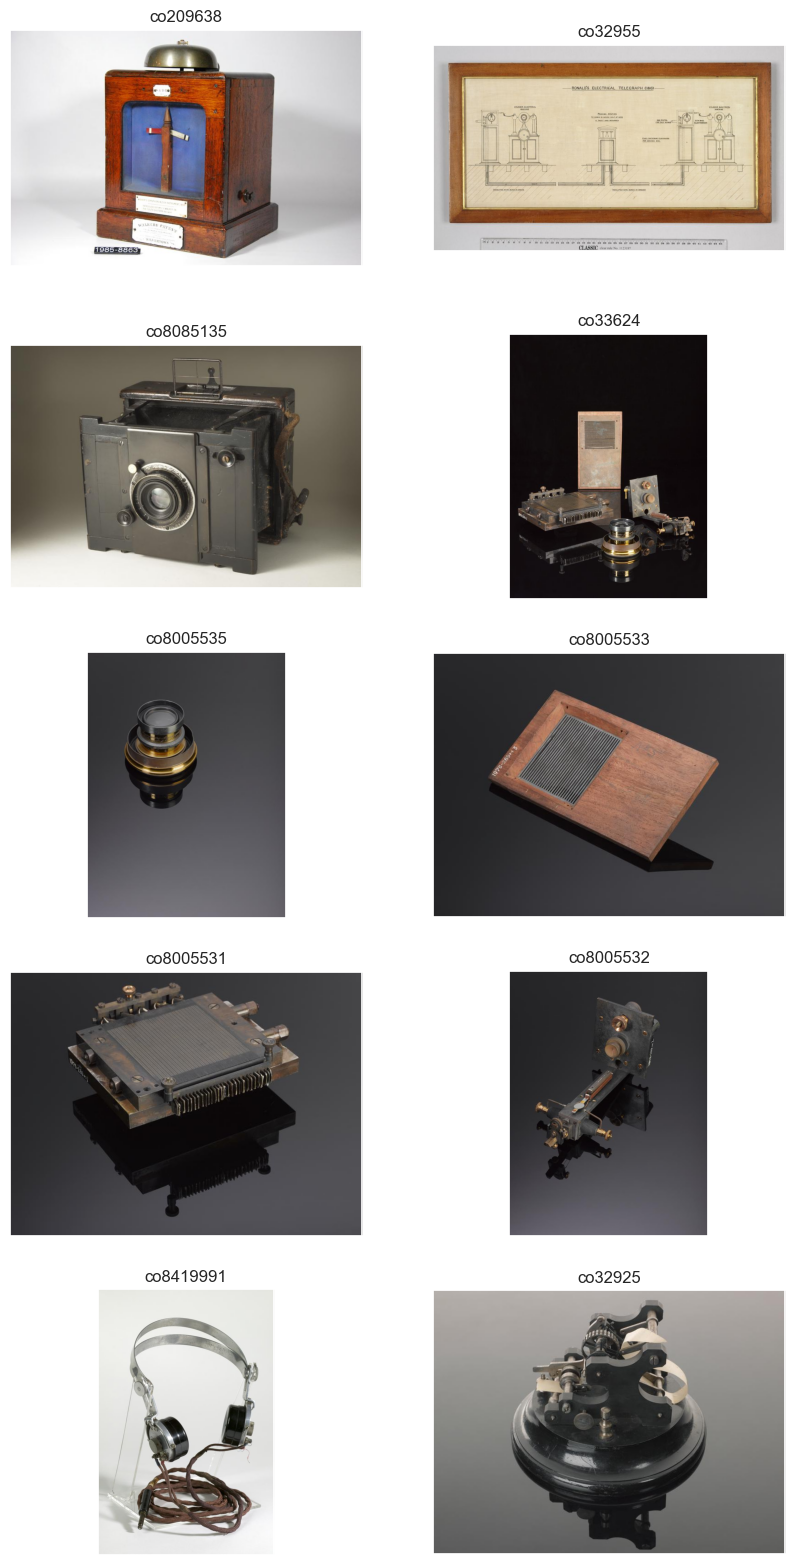

In [11]:
record = collection_df.iloc[1001]
results = collection_db.query(query_images=[record.img_path],n_results=top_n) # where=filters, 
query_df = plot_query_results(results, collection_df,source='img_url')

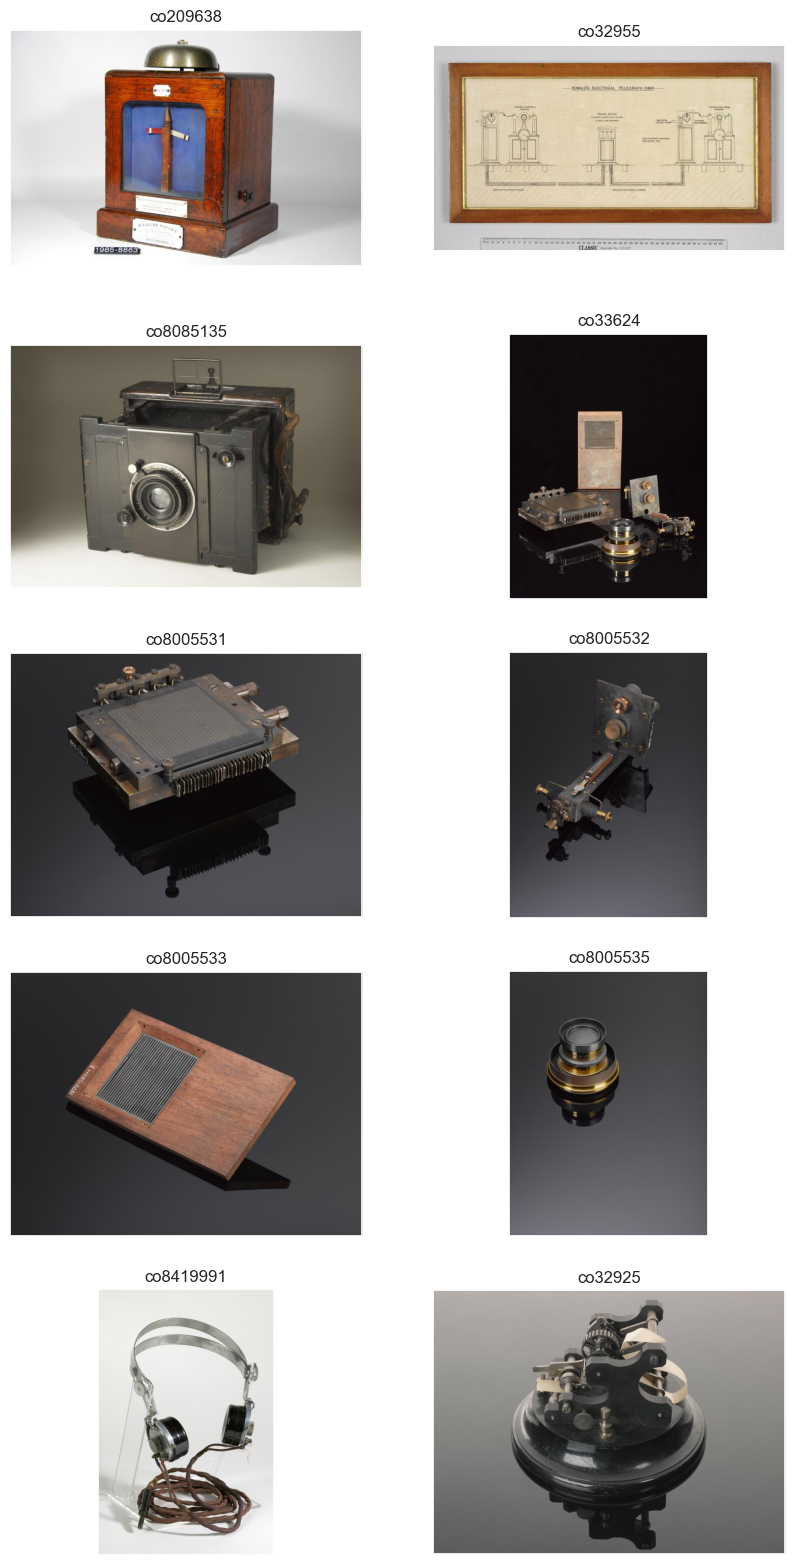

In [13]:
#root =  '/Users/kasparbeelen/Documents/CongruenceEngine/heritage-weaver/'

def label_studio_export(record, collection_df):
    results = collection_db.query(query_images=[record.img_path],n_results=25) # where=filters, 
    query_df = plot_query_results(results, collection_df,source='img_url')
    query_df['target_img'] = query_df.img_url#.apply(lambda x: root + x)
    query_df['source_img'] = record.img_url
    query_df[['target_img','source_img','record_id','description']].to_csv('test_labelstudio.csv')
    
label_studio_export(collection_df.iloc[1001],collection_df)

In [28]:
collection_df.iloc[1001].img_url

'https://coimages.sciencemuseumgroup.org.uk/images/366/806/medium_SMG00077459.jpg'

In [ ]:
img = collection_df.iloc[10].img_path

In [ ]:
results['metadatas']

In [ ]:
# query = 'https://i.ebayimg.com/images/g/4SUAAOSwOelisbt4/s-l1600.jpg'
# response = requests.get(query)
#img = Image.open(BytesIO(response.content))
results = collection_db.query(query_images=[img],n_results=top_n) # where=filters, 

In [ ]:
query_df

In [ ]:
query_df = plot_query_results(results, collection_df)
inputs = list(query_df.to_records()); len(inputs)

In [ ]:
img

In [ ]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['relevant', 'not relevant'], allow_freetext=False,
        display_function=plot_by_record)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(inputs.pop(0))
    except IndexError:
        print("Finished.")
        
widget.on_submit(store_annotations)
widget.display(inputs.pop(0))
widget

In [ ]:
query_df['labels'] = labels[:top_n]
query_df['query'] = query
query_df['modality'] = modality
query_df.to_csv(out_path / f'{annotator}_{time.time()}.csv')

In [ ]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

In [ ]:
device = "cpu" 
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [ ]:
# functions taken from
def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [ ]:
raw_image

In [ ]:
#img_url = "https://i.pinimg.com/originals/98/8c/2a/988c2a6dc0155e2aa1cf66142e85acf4.jpg"
#img_url = "https://i.pinimg.com/736x/43/32/18/433218ccd63087a6ba0c66336777a8cb.jpg"
img_url = 'https://image1.masterfile.com/getImage/ODQ2LTA1NjQ4NDM1ZW4uMDAwMDAwMDA=ADoG02/846-05648435en_Masterfile.jpg'
img_url = 'https://media.istockphoto.com/id/891337926/photo/beautiful-woman-with-vintage-phone.jpg?s=170667a&w=0&k=20&c=xXFnMliS5aWx4vOZIwnm6HaOW71HFCvYNTCKnO9rFRs='
#img_url = 'http://www.digitalarchives.bt.com/Calmview/GetImage.ashx?db=Catalog&type=default&fname=TCB_417_E54315.jpg'
#input_points = [[[420, 550]]] # 2D location of a window in the image
input_points = [[[2000,1000],[2500,800]]]
#input_points = [[[300,275],[200,250],[166,200],[140,140]]]
#input_points = [[[410,450],[250,400]]]
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
#raw_image = Image.open('/Users/kasparbeelen/Downloads/image.jpeg')
show_points_on_image(raw_image,input_points[0])

In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

In [ ]:
masks[0].shape

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

In [ ]:
last_mask = masks[0].squeeze(0)[1,:,:]

In [ ]:
masked_image = np.copy(raw_image)

    # Apply mask to each channel of the image
for i in range(3):  # assuming RGB image
    # Blank out pixels where mask is False
    masked_image[:, :, i] = np.where(last_mask[:, :] == False, 255, masked_image[:, :, i])


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.axis('off')

plt.show()

In [ ]:
#https://huggingface.co/spaces/merve/OWLSAM
img = Image.fromarray(masked_image)
img.save('test.jpg')
img = Image.open('test.jpg')
img

In [ ]:
!open .

# Link Annotation

In [ ]:
annotator = 'KB'
num_annotations = 10
to_annotate = edges[:num_annotations]
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'image', 'image'
percentile = 99.5
randomize = True

In [ ]:
filter_smg = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality1
            }
        },
        {
            "collection": {
                "$eq" : coll1
            }
        }
    ]
}


smg_data = collection_db.get(
                where=filter_smg,
                include=['embeddings','metadatas']

                    )

filter_nms = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality2
            }
        },
        {
            "collection": {
                "$eq" : coll2
            }
        }
    ]
}

nms_data = collection_db.get(
                where=filter_nms,
                include=['embeddings','metadatas']
            )

In [ ]:
smg_ids = smg_data['ids']
nms_ids = nms_data['ids']

smg_rids = [record['record_id'] for record in smg_data['metadatas']]
nms_rids = [record['record_id'] for record in nms_data['metadatas']]

smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
image_similarities = 1 - sp.distance.cdist(smg_emb,nms_emb, 'cosine')

threshold = np.percentile(image_similarities.reshape(-1), percentile) ; threshold

image_similarities[image_similarities >= threshold] = 1
image_similarities[image_similarities < threshold] = 0

sns.set(rc={'figure.figsize':(15.7,12.27)})

sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

In [ ]:
#image_similarities.sum(axis=1).sum()/(image_similarities.shape[0]*image_similarities.shape[1])

In [ ]:
smg_node_ids = list(np.where(image_similarities.sum(axis=1) > 0)[0])
nms_node_ids = list(np.where(image_similarities.sum(axis=0) > 0)[0])

smg_mapping = {i:j for i,j in zip(range(len(smg_data['embeddings'])),smg_rids)}
nms_mapping = {i:j for i,j in zip(range(len(nms_data['embeddings'])),nms_rids)}

In [ ]:
edges = [(smg_mapping[i],nms_mapping[j]) for i,j in zip(*np.where(image_similarities > 0))]

In [ ]:
print(len(edges))

In [ ]:
if randomize:
    random.shuffle(edges)
img_pairs = edges[:num_annotations]

In [ ]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['link', 'no link'], allow_freetext=True,
        display_function=plot_record_pair)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(img_pairs.pop(0))
    except IndexError:
        print("Finished.")
widget.on_submit(store_annotations)
widget.display(img_pairs.pop(0))
widget


In [ ]:
annotations_df = pd.DataFrame(to_annotate, columns=['coll1','coll2'])
annotations_df['labels'] = labels[:num_annotations]

In [ ]:
for varname, var in [('coll1_name',coll1), ('coll2_name',coll2), ('modality1',modality1), ('modality2',modality2)]:
    annotations_df[varname] = var

In [ ]:
annotations_df

In [ ]:
annotations_df.to_csv(out_path / f'{annotator}_{time.time()}')